# AFSK Digital Correlator Demodulator

This notebook contains my notes on the 1200 baud AFSK demodulator presented
in [PSoC ® 1 - Simplified FSK Detection (AN2336)](http://www.cypress.com/go/AN2336)
by Dennis Seguine for Cypress Semiconductor.

The demodulator used in the Mobilinkd TNC3 uses this method to demodulate AFSK
data.  This expands on that application note to show a complete HDLC packet
demodulator/decoder.

The purpose of this design is to demodulate 1200 baud amateur radio
packet data.  This encompasses the following topics:

 * AFSK Demodulation
 * Clock Recovery
 * Data Carrier Detection
 * HDLC Decoding
 * AX.25 Packet Parsing

## AFSK Basics

AFSK -- audio frequency shift keying -- is a method of sending data by
alternating two tones, called *mark* and *space*, to transmit binary
data.

Amateur radio packet data uses the [Bell 202 modem specification](https://en.wikipedia.org/wiki/Bell_202_modem), which specifies a 1200 baud data rate, 1200Hz mark and 2200Hz space tones, a
+/- 10Hz accuracy, and a 1dB flatness for the audio signal.  AFSK modems
are phase-continuous, meaning that there are no abrupt phase changes when
switching between mark and space tones.

### NRZI

The tones themselves do not encode 0/1 directly.  Rather a [non-return
to zero, inverted (NRZI)](https://en.wikipedia.org/wiki/Non-return-to-zero)
scheme is used.  What this means in laymans terms is that rather than the
tones themselves, it is a change in tone that encodes the data.  In NRZI,
a change in tone encodes a 0 and no change in tone encodes a 1.

## AFSK Challenges

Digital signal processing of AFSK data presents a number of challenges.
At the most rudimentary level we have to deal with noise in the signal
and have to overcome low SNR.  In practice, low SNR is actually the least
of our worries.  we are focused on AFSK over FM, which provides a fairly
low SNR until it hits a cliff and falls off very fast.

A much more serious problem we face is twist.  Twist is the amplitude
difference between mark and space tones.  Recall that the Bell 202 spec
requires a 1dB flatness.  Over an amateur radio voice channel, at its
worst we can have twist of +/-9dB and absolutely must handle twist of
6dB.

 1. The voice channel is emphasized on transmission and de-emphasized on
    reception.  Pre-emphasis adds about 6dB to the space tone and then
    subtracts 6dB during de-emphasis.
 2. Not all radios do pre-emphasis.  This can cause up to 6dB in twist
    when received on a radio that does de-emphasis.
 3. Radios that do pre-emphasis may clip the signal after emphasis. This
    causes the higher tone to be lower in amplitude when de-emphasized.
    This can cause up to 6dB in twist when de-emphasized.
 4. Some people may use radios that do not apply de-emphasis.  This may
    present 6dB twist to the modem in the other direction.

It should be noted that Kenwood radio equipment do not apply pre-emphasis
to their AFSK audio when transmitting.

Because AFSK is send over a voice channel, and is sent and received
using equipment designed for voice communication, we have to deal with
audio processing artifacts that are typically avoided in data transmission.
The audio filters, pre-emphasis and de-emphasis filters and limiters used
can cause phase shifts in audio that is imperceptible to human ears but
which can lead to inter-symbol interference (ISI) when sending data.

At least one major TNC manufacturer substituted V.23 modem chips (rather
than Bell 202) in their product  for a time, causing tones to by out of
spec by 100Hz.

All modern digital communications standards use some form of forward
error correction (FEC).  1200 baud packet radio uses no FEC.  A one-bit
error will prevent a packet from being properly decoded.

So, to summarize, our modem must deal with:

 * Low SNR -- noise on top of the actual data signal
 * High twist -- large differences in amplitude between mark and space tones
 * Phase distortion -- mark and space tones not arriving at symbol boundaries
 * Inter-symbol interference -- mark and space tones overlapping due to phase distortion
 * Frequency distortion -- large differences in tone frequency and data rate
 * No error correction -- one bit errors are fatal

These issues make demodulating an APRS signal a little more challenging
than 1200 baud over POTS.  In order to acheive best in class performance
the demodulator needs to address all of these issues.

## AFSK Demodulation

This is a digital correlator demodulator.  It is very simple to implement.
It consumes very little resources. And it is fairly tolerant of twist.

This is the modem implementation used (implemented completely in software)
in the Mobilinkd TNC3.


## What is a Digital Correlator

The correlator involves little more than multiplying the input
signal with a delayed copy of itself.  It is a [comb filter](https://en.wikipedia.org/wiki/Comb_filter).
It causes the signal to destructively and constructively interfere with
itself in such a manner as to demodulate the encoded bitstream.  By adjusting
the delay, we can maximize the difference between mark and space tones.

A digital correlator invovles converting the analog signal into a digital
one by way of a zero-crossing detector, and then applying the same delay
as one would with an analog comb filter.

An analog comb filter is sensitive to twist and is more costly to implement
than a digital one.  A digital correlator is more sensitive to low-frequency
noise and simpler to implement in code or digital circuitry.

Note: it may be cheaper to deal with the twist issues with an analog
comb filter.

  $y[n]=x[n]+\alpha x[n-K]$

Where $\alpha$ is a scaling factor that involves a single multiply per
sample.

### Finding the Right Delay

As mentioned above, we are designing a comb filter whose goal is to
maximize the difference between mark and space tones.  This is a
problem summed up by:

$Diff = cos(2\pi f_L d) - cos(2 \pi f_H d)$

where $f_L$ is the low freqency, $f_H$ is the high frequency and $d$ is the delay.

If we graph this equation, we should see what delays provides the biggest differences between the two tones.

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt

def plot_to_notebook(time_sec,mark_signal,space_signal,corr_signal,n_samples):
    plt.figure()
    plt.subplot(1, 1, 1)
    plt.xlabel('Time (msec)')
    plt.grid()
    plt.plot(time_sec[:n_samples]*1000,mark_signal[:n_samples],'y-',label='Mark signal')
    plt.plot(time_sec[:n_samples]*1000,space_signal[:n_samples],'g-',label='Space signal')
    plt.plot(time_sec[:n_samples]*1000,corr_signal[:n_samples],'r-',linewidth=2,label='Correlation')
    plt.legend()

Number of samples:  1000


<IPython.core.display.Javascript object>


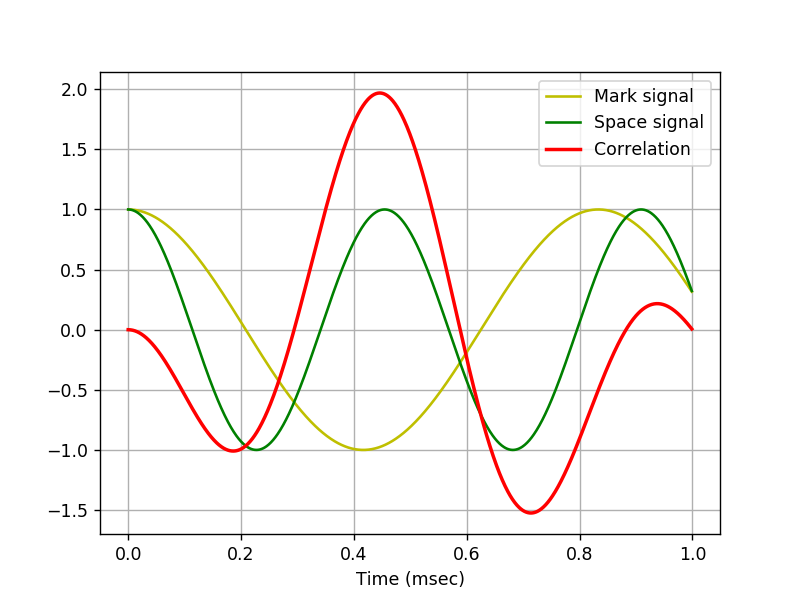

In [13]:
import numpy as np

# Total time
T = 0.001
# Sampling frequency
fs = 1e6
# Number of samples
n = int(T * fs)
# Time vector in seconds
t = np.linspace(0, T, n, endpoint=False)
# Samples of the signals
mark = np.cos(1200*2*np.pi*t)
space = np.cos(2200*2*np.pi*t)
corr =  np.cos(2200*2*np.pi*t) - np.cos(1200*2*np.pi*t)
# Convert samples to 32-bit integers
# samples = samples.astype(np.int32)
print('Number of samples: ',n)

# Plot signal to the notebook
plot_to_notebook(t,mark,space,corr,1000)

Here we see that a time of 446us will lead to a difference of 2.  This matches the value given in the application note.

As mentioned above, some of the modems found in the wild on APRS actually use the
V.23 standard.  This has a different maximum correlator offset.

Let's plot this now.

Number of samples:  1000


<IPython.core.display.Javascript object>


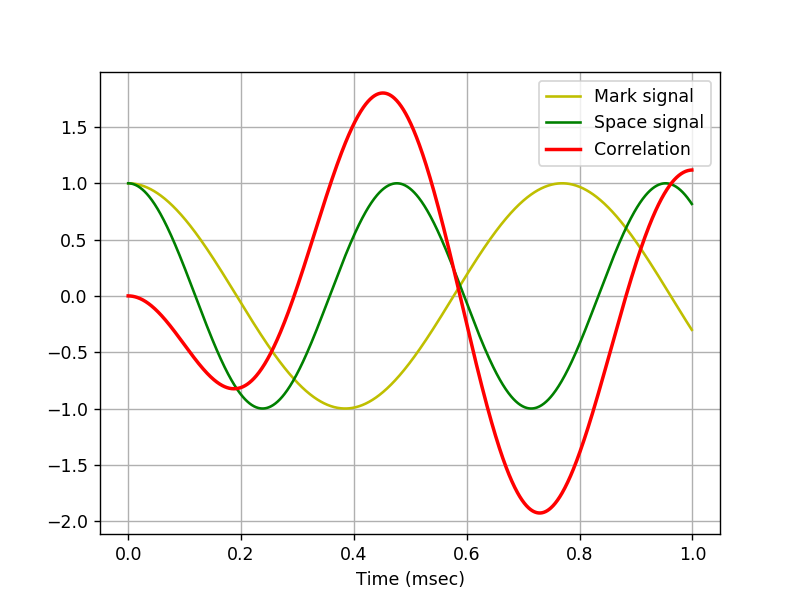

In [14]:
import numpy as np

# Total time
T = 0.001
# Sampling frequency
fs = 1e6
# Number of samples
n = int(T * fs)
# Time vector in seconds
t = np.linspace(0, T, n, endpoint=False)
# Samples of the signals
mark = np.cos(1300*2*np.pi*t)
space = np.cos(2100*2*np.pi*t)
corr =  np.cos(2100*2*np.pi*t) - np.cos(1300*2*np.pi*t)
# Convert samples to 32-bit integers
# samples = samples.astype(np.int32)
print('Number of samples: ',n)

# Plot signal to the notebook
plot_to_notebook(t,mark,space,corr,1000)

Notice that the maximum is at 730us.  However, the first correlation maximum
corresponds nicely with the maximum for the Bell 202 standard, with a value
of 1.8.  According to the application note, this should be good enough.

We can try some empircal tests later to determine if using a 730us delay
has a meaningful impact.

Towards the end of the application note, the author states that the sample rate
should be an integer multiple of the two tones.  It is impossible to find a
reasonable sample rate that meets this criterion for both Bell 202 and V.23 since
the two standards have integer multiples of 2, 3, 7, 11 and 13 (it would be
6,006,000 samples per second).

<sub>This difference in sample rate may be more significant than the correlator delay.</sub>

## Implementation

This section will start the implementation of the correlator.  To start, we
will load a 1 second audio file from a [WA8LMF APRS packet test track](http://wa8lmf.net/TNCtest/). 
This is from 10 seconds into track 2.  This is chosen because this one-second
snippet is known to have data at the start, noise in the middle, and a complete
packet towards the end.

The sample file was generated using the following command:

    $ sox TNC_Test_Ver-1.102.wav TNC_Test_Ver-1.102-26400-1sec.wav trim 10 1 rate 26400 channels 1

We will use scipy to read the WAV file.  The audio file is a tuple containing
the sample rate and a numpy array of audio data.  Because this is a single
channel sample, the array is 1-dimensional.

In [4]:
from scipy.io.wavfile import read

audio_file = read('TNC_Test_Ver-1.102-26400-1sec.wav')
print(audio_file)

(26400, array([ 720,  748,  468, ..., 3353, 3049, 2230], dtype=int16))


### Audio Visualization

Lets look at what the audio signal looks like.  The audio picks up in the
middle of a packet transmission, so we should see live data.  The sample
rate is selected to have an integer multiple of the data rate (1200 bps).

Let's look at the first few bits.

Number of samples:  220


<IPython.core.display.Javascript object>


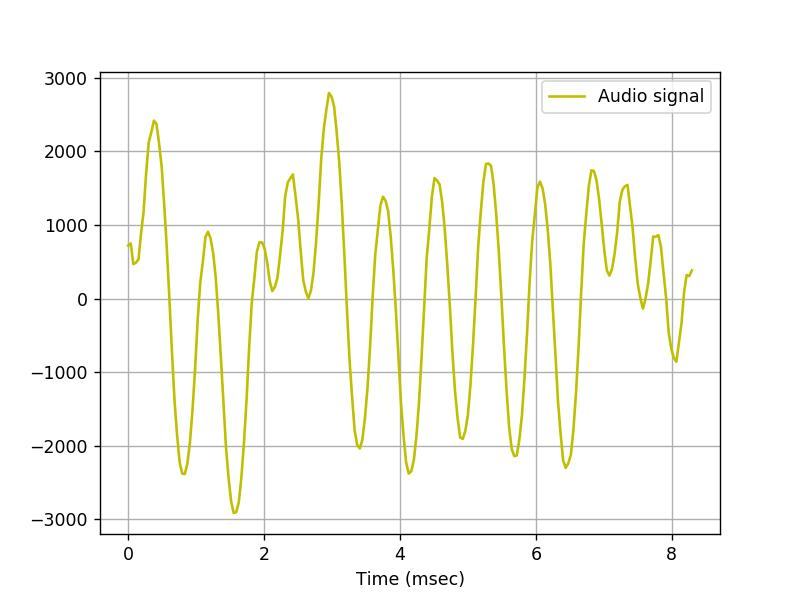

In [15]:
sample_rate = audio_file[0]
audio_data = audio_file[1]

def plot_audio(time_sec,n_samples,signal,filtered=None):
    plt.figure()
    plt.subplot(1, 1, 1)
    plt.xlabel('Time (msec)')
    plt.grid()
    plt.plot(time_sec[:n_samples]*1000,signal[:n_samples],'y-',label='Audio signal')
    if filtered is not None:
        plt.plot(time_sec[:n_samples]*1000,filtered[:n_samples],'g-',label='Filtered signal')
    plt.legend()

# Total time
T = 10.0 / 1200.0
# Sampling frequency
fs = sample_rate
# Number of samples
n = int(T * fs)
# Time vector in seconds
t = np.linspace(0, T, n, endpoint=False)

print('Number of samples: ',n)

# Plot signal to the notebook
plot_audio(t,n,audio_data)

This is a rather noisy signal.  For one thing, there are low-frequency
components that would make digitizing this signal problematic.  We need
to filter this signal.

To do this, we construct a band-pass filter using our trusty online
filter resource: http://t-filter.engineerjs.com/

<IPython.core.display.Javascript object>


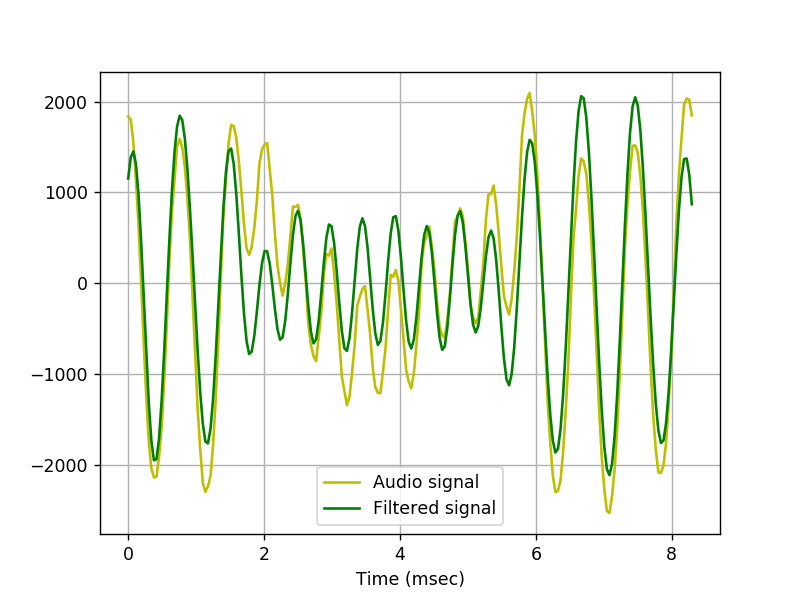

In [16]:
from scipy.signal import lfiltic, lfilter

class fir_filter(object):
    def __init__(self, coeffs):
        self.coeffs = coeffs
        self.zl = lfiltic(self.coeffs, 32768, [], [])
    def __call__(self, data):
        result, self.zl = lfilter(self.coeffs, 32768, data, -1, self.zl)
        return result

"""
FIR filter designed with
http://t-filter.appspot.com

sampling frequency: 26400 Hz

fixed point precision: 16 bits

* 0 Hz - 800 Hz
  gain = 0
  desired attenuation = -40 dB
  actual attenuation = n/a

* 1100 Hz - 2300 Hz
  gain = 1
  desired ripple = 1 dB
  actual ripple = n/a

* 2700 Hz - 13200 Hz
  gain = 0
  desired attenuation = -40 dB
  actual attenuation = n/a
"""
bpf_coeffs = [212,98,82,39,-27,-102,-168,-207,-210,-174,-109,-34,32,69,72,43,-1,-37,
  -44,-10,62,156,244,296,291,222,103,-37,-161,-236,-245,-195,-109,-29,7,-25,-124,-264,
  -395,-465,-430,-278,-33,253,506,660,676,555,346,125,-23,-34,104,349,602,741,653,279,
  -365,-1170,-1962,-2531,-2694,-2340,-1474,-221,1192,2485,3389,3714,3389,2485,1192,-221,
  -1474,-2340,-2694,-2531,-1962,-1170,-365,279,653,741,602,349,104,-34,-23,125,346,555,
  676,660,506,253,-33,-278,-430,-465,-395,-264,-124,-25,7,-29,-109,-195,-245,-236,-161,
  -37,103,222,291,296,244,156,62,-10,-44,-37,-1,43,72,69,32,-34,-109,-174,-210,-207,
  -168,-102,-27,39,82,98,212]
    
bpf = fir_filter(bpf_coeffs)

filter_delay = len(bpf_coeffs)//2

delay = 12

samples = n+filter_delay+delay
audio_samples = audio_data[140:140+samples]
filtered_audio = bpf(audio_samples)[filter_delay:]
plot_audio(t,n,audio_samples,filtered_audio)

Note that the low-frequency component has been mostly eliminated, allowing
a zero-crossing digitizer to work properly.  The importance of band-pass
filtering of the input audio signal cannot be overstated.

## Digitizing the Audio Signal

Now lets look at what happens when we digitize the audio signal.

<IPython.core.display.Javascript object>


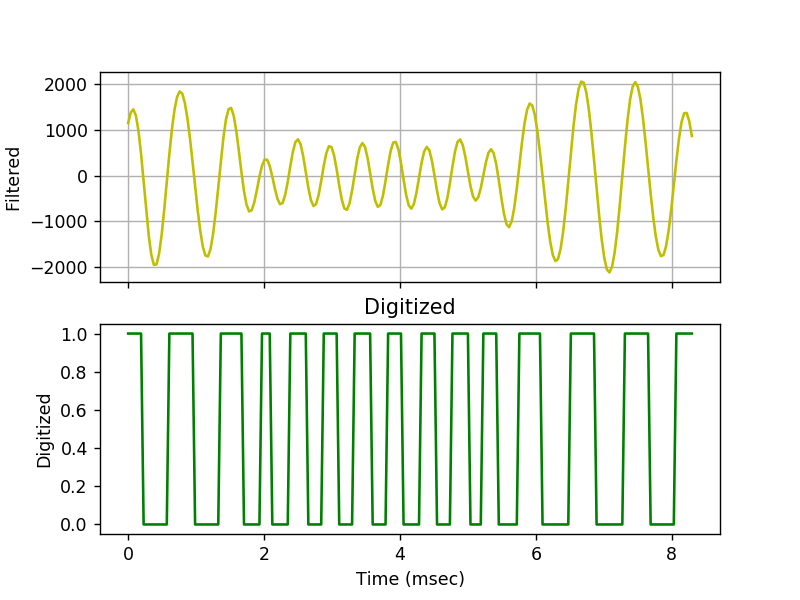

Text(0,0.5,'Digitized')

In [17]:
digitized = np.array([int(x > 0) for x in filtered_audio])

fig, ax = plt.subplots(2, sharex=True)
plt.xlabel('Time (msec)')
plt.title("Digitized")

ax[0].plot(t[:n]*1000,filtered_audio[:n],'y-')
ax[0].set_ylabel("Filtered")
ax[0].grid()
ax[1].plot(t[:n]*1000,digitized[:n],'g-')
ax[1].set_ylabel("Digitized")


The *mark* and *space* tones, visible in the analog input, are also
apparent in the digitized form.

### Comb Filter

Recall that a correlator is a comb filter -- a signal that is multiplied by
a delayed version of itself.  In the binary world, XOR will accomplish the
multiplication in the binary domain.

Lets take a look at the digital version, it's delayed version, and the correlator
output.

<IPython.core.display.Javascript object>


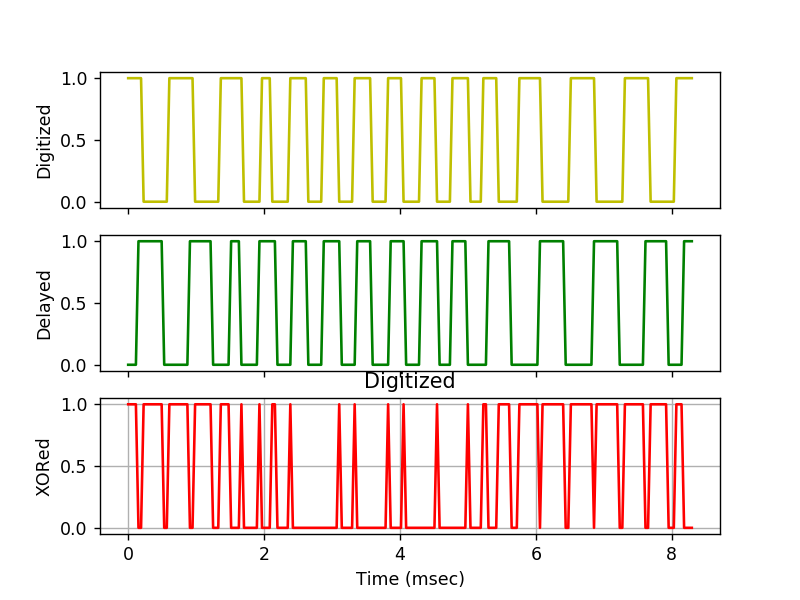

Text(0,0.5,'XORed')

In [18]:
delayed = digitized[delay:]
xored = np.logical_xor(digitized[:0-delay], delayed)

fig, ax = plt.subplots(3, sharex=True)
plt.xlabel('Time (msec)')
plt.title("Digitized")
plt.grid()
ax[0].plot(t[:n]*1000,digitized[:n],'y-')
ax[0].set_ylabel("Digitized")
ax[1].plot(t[:n]*1000,delayed[:n],'g-')
ax[1].set_ylabel("Delayed")
ax[2].plot(t[:n]*1000,xored[:n],'r-')
ax[2].set_ylabel("XORed")

Now that we have digitally correlated the data, the XORed data has the
appearance of a pulse-wide modulated (PWM) signal.  We will need to
normalize and low-pass filter this.  Subtracting 0.5 and the passing
the signal through another FIR filter with a cut-off at 760 Hz will
give us the demodulated signal in analog form.

<IPython.core.display.Javascript object>


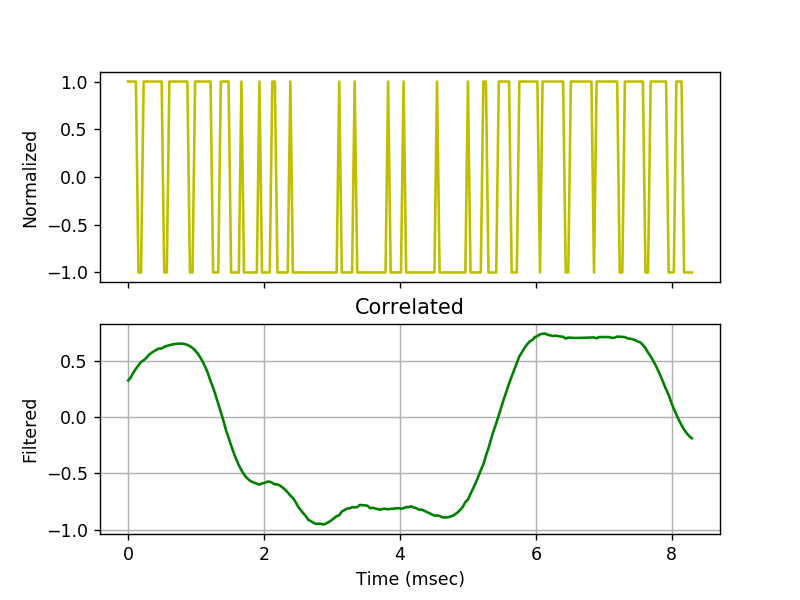

Text(0,0.5,'Filtered')

In [79]:
"""
FIR filter designed with
http://t-filter.appspot.com

sampling frequency: 26400 Hz

fixed point precision: 16 bits

* 0 Hz - 760 Hz
  gain = 1
  desired ripple = 1 dB
  actual ripple = n/a

* 1200 Hz - 13200 Hz
  gain = 0
  desired attenuation = -40 dB
  actual attenuation = n/a
"""

lpf_coeffs = [
  -176,-49,-51,-49,-42,-31,-15,5,30,58,88,119,149,176,198,213,220,217,203,177,139,
  90,31,-35,-107,-180,-252,-318,-373,-414,-436,-436,-410,-357,-274,-161,-20,147,
  338,549,773,1005,1238,1466,1680,1876,2045,2183,2285,2348,2369,2348,2285,2183,
  2045,1876,1680,1466,1238,1005,773,549,338,147,-20,-161,-274,-357,-410,-436,-436,
  -414,-373,-318,-252,-180,-107,-35,31,90,139,177,203,217,220,213,198,176,149,119,
  88,58,30,5,-15,-31,-42,-49,-51,-49,-176]
lpf = fir_filter(lpf_coeffs)

normalized = (xored - 0.5) * 2.0
correlated = np.append(lpf(normalized), lpf(np.zeros(len(lpf_coeffs))))[len(lpf_coeffs)//2:] # push through zeros to empty filter

fig, ax = plt.subplots(2, sharex=True)
plt.xlabel('Time (msec)')
plt.title("Correlated")
plt.grid()
ax[0].plot(t[:n]*1000,normalized[:n],'y-')
ax[0].set_ylabel("Normalized")
ax[1].plot(t[:n]*1000,correlated[:n],'g-')
ax[1].set_ylabel("Filtered")

Now that we have the data in analog form, we just need to re-digitize
the data by passing it through a zero-crossing detector.  A little
hysteresis may be warranted.  We will ignore that here.

<IPython.core.display.Javascript object>


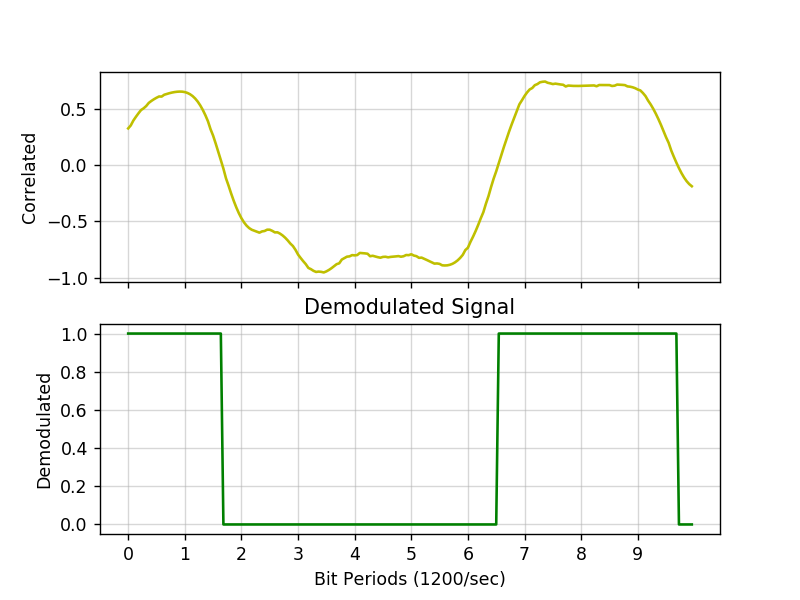

In [80]:
demodulated = np.array([int(x > 0) for x in correlated])

fig, ax = plt.subplots(2, sharex=True)
plt.xlabel('Bit Periods (1200/sec)')
plt.title("Demodulated Signal")

plt.grid(which='minor', alpha=0.2)
plt.grid(which='major', alpha=0.5)
plt.xticks(np.arange(0, 10, 1))

ax[0].plot(t[:n]*1200,correlated[:n],'y-')
ax[0].set_ylabel("Correlated")
ax[0].grid(which='major', alpha=0.5)

ax[1].plot(t[:n]*1200,demodulated[:n],'g-')
ax[1].set_ylabel("Demodulated")
ax[1].grid(which='minor', alpha=0.2)
ax[1].grid(which='major', alpha=0.5)


Note that we have now switched our X axis to "bit periods" rather than ms.
Each bit period is 866us.  Now that we have demodulated out signal, what
do we do?

## Clock Recovery

Actually, the hardest part is now before us.  We must implement *Clock
Recovery*.  This does two things:

 1. Determines whether we are tracking a data signal or listening to noise.
 2. Recovers the sender's clock.
 
The Bell 202 specification requires that the tones and the data clock be
within +/- 10Hz <sup>1</sup>.

There is an engineering trade-off to be made here.  Locking on to clocks that
vary by more than the 10Hz permitted allow a modem to decode signals from
poorly-implemented modems.  However, this can also prevent us from otherwise
locking to weak signals of well-implemented modems.

My experience has been that Kenwood equipment will frequently fail to decode
otherwise strong signals whose data rates are outside the 10Hz range specified.

<sup>1</sup> http://www.softelectro.ru/bell202_en.html

### Eye Diagrams

What we are attempting to do conceptually is to construct an eye diagram, determine
the width of the eye wall or conversely the eye opening, and find the center of the
eye opening.

With the first 6 lines of code, we are going demodulate the first 30 symbols of
our test data and plot those in a window that is exactly two bit-lengths wide.
This will give us an eye diagram.

<IPython.core.display.Javascript object>


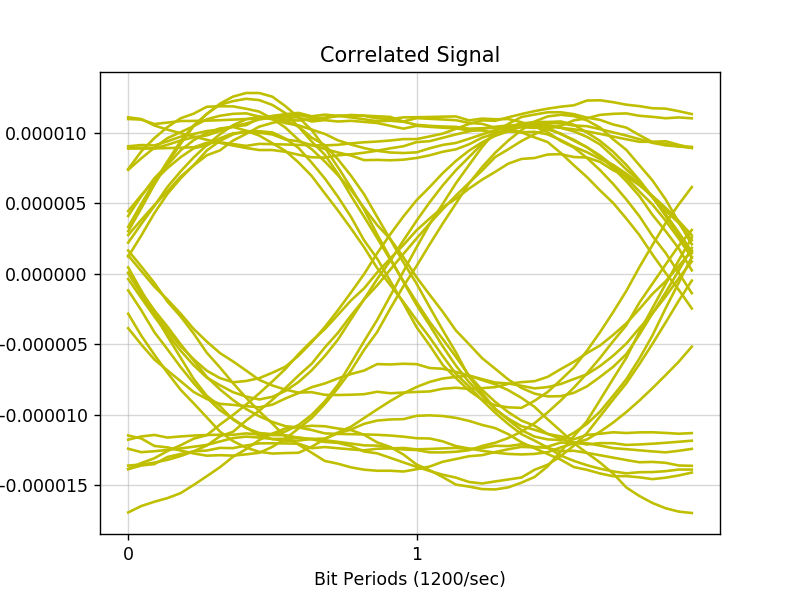

In [21]:
# Select the audio data to demodulate (first 60 bits)
s = audio_data[:22*60 + delay]
# Band-pass filter the audio data
f = np.append(bpf(s), bpf(np.zeros(len(bpf_coeffs)//2)))[len(bpf_coeffs)//2:]
# Digitize the data
d = np.array([int(x > 0) for x in f])
# Delay the data
a = d[delay:]
# XOR the digitized data with the delayed version
x = np.logical_xor(d[:0-delay], a)
# Low-pass filter the PWM signal
c = np.append(lpf(x-0.5), lpf(np.zeros(len(lpf_coeffs)//2)))[len(lpf_coeffs)//2:]

fig, ax = plt.subplots(1, sharex=True)
plt.xlabel('Bit Periods (1200/sec)')
plt.title("Correlated Signal")

plt.grid(which='major', alpha=0.5)
plt.xticks(np.arange(0, 2, 1))

ax.set_ylabel("Correlated")
ax.grid(which='major', alpha=0.5)

for i in range(0, len(c), 44):
    ax.plot(t[:44]*1200,c[i:i+44]/32768,'y-')
    

Here one can see the first 60 bit periods of the correlated output.  The
eye is open, there is some jitter around the eye walls, and it is not
centered.  Our job is to write code to quanitify the "openness" of the
eye and to track its center.

Doing this requires that we see a number of mark/space transitions in
order to build up the image above, just as we do to lock the PLL below.
This is the purpose of the preamble (TX Delay) sent with a packet.  It
allows a demodulator to see a number of transistions and lock a PLL to
the data carrier.  Set the TX Delay value too small and the demodulator
on the remote end may not be able to lock in time.

If we plot the digitized demodulated signal, this is what we see:

<IPython.core.display.Javascript object>


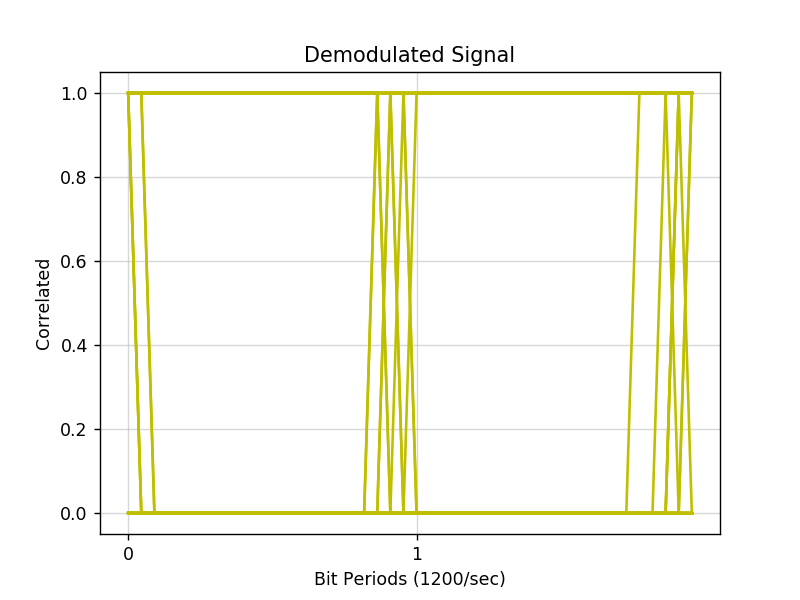

In [28]:
# Digitize the correlated output.
dx = np.array([int(x > 0) for x in c])

fig, ax = plt.subplots(1, sharex=True)
plt.xlabel('Bit Periods (1200/sec)')
plt.title("Demodulated Signal")

plt.grid(which='major', alpha=0.5)
plt.xticks(np.arange(0, 2, 1))

ax.set_ylabel("Correlated")
ax.grid(which='major', alpha=0.5)

for i in range(0, len(dx), 44):
    ax.plot(t[:44]*1200,dx[i:i+44],'y-')


With the digitized signal, the task is a little easier to understand.  We just need to
determine whether the width of the eye wall (the signal jitter) matches a specified
threshold.  The openness of the eye, or conversely the thinness of the eye wall,
allows us to measure the carrier signal.  We need a threshold value at which we
say that carrier is detected.  The value we use was determined empirically.

We also determined that we need to allow for some amount of slack after the signal is
locked in order to deal with noise.

Note here that a single noise event would show up as a transition in the middle of
the eye.  We may be able to use that for error detection and correction.

Note that already, with only a few lines of Python code, we can demodulate an AFSK signal.

### Digital PLL

In order to do clock recovery, we need to implement a digital PLL.  This requires
a couple of supporting classes -- an IIR filter for loop and lock filtering, and
hysteresis for locking/unlocking.

Let's implement a digital PLL.

In [73]:
class iir_filter(object):
    def __init__(self, b, a):
        self.b = b
        self.a = a
        self.zl = lfiltic(self.b, self.a, [], [])
    def __call__(self, data):
        result, self.zl = lfilter(self.b, self.a, [data], -1, self.zl)
        return result[0]

class Hysteresis:

    def __init__(self, minimum, maximum, low = -1, high = 1, start  = -1):

        self.minimum = minimum
        self.maximum = maximum
        self.low = low
        self.high = high
        self.value = start

    def check(self, value):
    
        if value <= self.minimum:
            self.value = self.low
        elif value >= self.maximum:
            self.value = self.high
        
        return self.value

    def __call__(self, data):

        try:
            return np.array([self.check(x) for x in data])
        except TypeError:
            return self.check(data)

class DigitalPLL:

    # 64Hz Bessel Filter for Loop
    loop_b = [
        0.144668495309,
        0.144668495309]
    
    loop_a  = [
        1.0,
        -0.710663009381]
    
    # 40Hz Bessel Filter for Lock
    lock_b = [
        0.0951079834025,
        0.0951079834025]
   
    lock_a  = [
        1.0,
        -0.809784033195]


    def __init__(self, sample_rate, symbol_rate):
        self.sample_rate_ = sample_rate
        self.symbol_rate_ = symbol_rate
        self.sps_ = sample_rate / symbol_rate   ##< Samples per symbol
        self.limit_ = self.sps_ / 2             ##< Samples per symbol / 2
        self.lock_ = Hysteresis(self.sps_ * 0.025, self.sps_ * 0.15, 1, 0)
        self.loop_lowpass = iir_filter(self.loop_b, self.loop_a)
        self.lock_lowpass = iir_filter(self.lock_b, self.lock_a)
    
        self.last_ = False
        self.count_ = 0.0
    
        self.sample_ = False
        self.jitter_ = 10.0
        self.bits_ = 1.0

    def __call__(self, input):
        
        self.sample_ = False;
        
        if (input != self.last_ or self.bits_ > 127.0):
            # Record transition.
            self.last_ = input

            if (self.count_ > self.limit_):
                self.count_ -= self.sps_
                        
            offset = self.count_ / self.bits_

            j = self.loop_lowpass(offset)
            self.jitter_ = self.lock_lowpass(abs(offset))
            
            # Advance or retard if not near a bit boundary.
            self.count_ -=  j * self.sps_ * 0.023
            
            self.bits_ = 1.0
        else:
            if (self.count_ > self.limit_):
                self.sample_ = True
                self.count_ -= self.sps_
                self.bits_ += 1

        self.count_ += 1.0
        return self.sample_
    
    def locked(self):
        return self.lock_(self.jitter_)

    
    def jitter(self):
        return self.jitter_

What the digital PLL allows us to do is measure the jitter, determine based on the jitter level
whether it is locked to a data carrier, and signal the expected center of the eye for sampling.

Jitter is measured as the absolute value difference from the expected symbol duration (here exactly
22 samples).  The PLL can be either advanced or retarded when a tone transition occurs depending on
whether the transition was later than expected or earlier.

Hysteresis is used to lock/unlock the PLL.  In order to lock we require the jitter to be
1.1 samples wide or less.  And it will unlock when jitter rises above 4.4 samples.

The PLL outouts a signal when at the center of the eye -- when it is most likely to be truly high
or truly low.

### Reading the Bitstream

Now that we have our PLL, lets take a look at what happens when we lock onto the data stream.

<IPython.core.display.Javascript object>


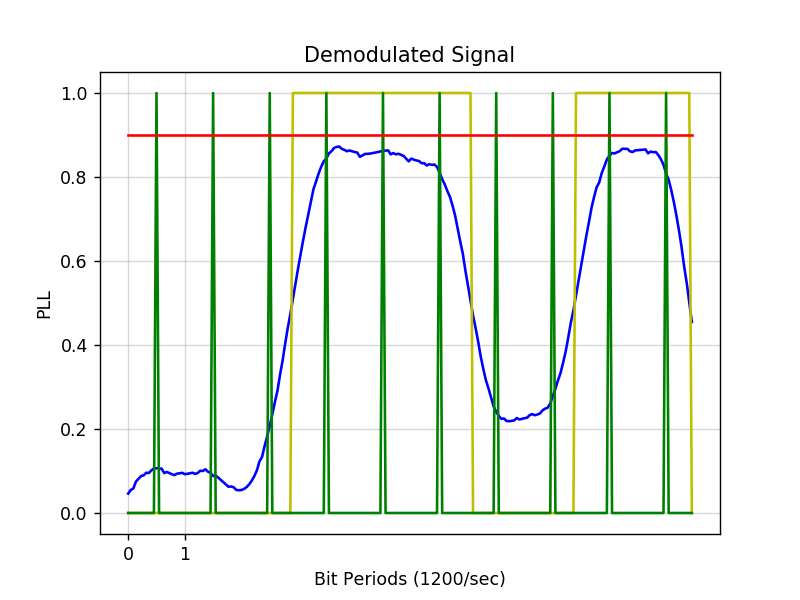

In [74]:
pll = DigitalPLL(sample_rate, 1200.0)

locked = np.zeros(len(dx), dtype=int)
sample = np.zeros(len(dx), dtype=int)

for i in range(len(dx)):
    sample[i] = pll(dx[i])
    locked[i] = pll.locked()

# Total time
T = 10.0 / 1200.0
# Number of samples
n = int(T * fs)
# Time vector in seconds
t = np.linspace(0, T, n, endpoint=False)

fig, ax = plt.subplots(1, sharex=True)
plt.xlabel('Bit Periods (1200/sec)')
plt.title("Demodulated Signal")

plt.grid(which='major', alpha=0.5)
plt.xticks(np.arange(0, 2, 1))

ax.set_ylabel("PLL")
ax.grid(which='major', alpha=0.5)

ax.plot(t*1200,c[220:440]+0.5,'b-')
ax.plot(t*1200,dx[220:440],'y-')
ax.plot(t*1200,sample[220:440],'g-')
ax.plot(t*1200,locked[220:440] * 0.8 + 0.1,'r-')

Here you can see that the PLL has locked onto the data (red line high). The
green spikes are the signals to tell the demodulator when to sample -- when
it is at the center of the bit/eye.  And you can see that the bit transitions
happen well away from the eye.

### NRZI

Our next job is to translate these tones (and tone changes) into a
bitstream.  For that, we need to implement the NRZI algorithm.

In [52]:
class NRZI:

    def __init__(self):

        self.state = False

    def __call__(self, x):
        
        result = (x == self.state)
        self.state = x
        return result

nrzi = NRZI()
    
data = [int(nrzi(x)) for x,y in zip(dx, sample) if y]
print(data, len(data))

[0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1] 60


Here you can see the actual bitstream that we have demodulated from the first 50ms of the audio file.

We cannot actually do anything with this data.  The data at the beginning of this one second
of audio is the very tail end of a packet.  But lets take a look at the entire second of audio.

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


<IPython.core.display.Javascript object>


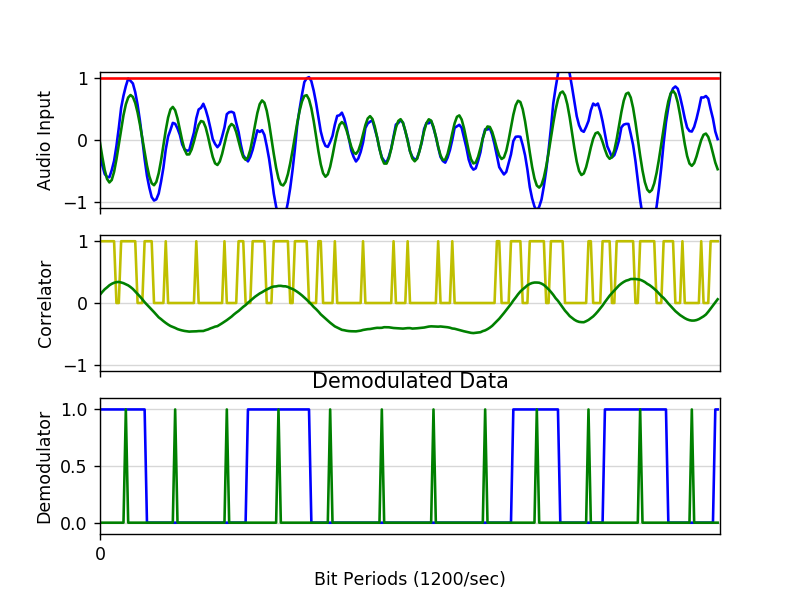

In [78]:
from matplotlib import animation, rc
from IPython.display import HTML

# Band-pass filter the audio data
f = np.append(bpf(audio_data), bpf(np.zeros(filter_delay)))[filter_delay:]
# Digitize the data
d = np.array([int(x > 0) for x in f])
# Delay the data
a = d[delay:]
# XOR the digitized data with the delayed version
x = np.logical_xor(d[:0-delay], a)
# Low-pass filter the PWM signal
c = np.append(lpf(x-0.5), lpf(np.zeros(len(lpf_coeffs)//2)))[len(lpf_coeffs)//2:]
# Digitize the tone transistions
dx = np.array([int(x > 0) for x in c])
# Create the PLL
pll = DigitalPLL(sample_rate, 1200.0)

locked = np.zeros(len(dx), dtype=int)
sample = np.zeros(len(dx), dtype=int)

# Clock recovery
for i in range(len(dx)):
    sample[i] = pll(dx[i]) & pll.locked()
    locked[i] = pll.locked()
    
nrzi = NRZI()
    
data = [int(nrzi(x)) for x,y in zip(dx, sample) if y]

# print(len(audio_data), len(f), len(d), len(a), len(x), len(c), len(dx))

# Time vector in seconds
t = np.linspace(0, .01, sample_rate/100.0, endpoint=False)

fig, ax = plt.subplots(3, sharex=True)
plt.xlabel('Bit Periods (1200/sec)')
plt.title("Demodulated Data")

plt.grid(which='major', alpha=0.5)
plt.xticks(np.arange(0, 2, 1))

ax[0].set_ylabel("Audio Input")
ax[0].grid(which='major', alpha=0.5)
ax[0].set_ylim(-1.1, 1.1)
ax[0].set_xlim(0.0,0.01)

in_line, = ax[0].plot([], [], 'b-')
bpf_line, = ax[0].plot([], [], 'g-')
lock_line, = ax[0].plot([], [], 'r-')

ax[1].set_ylabel("Correlator")
ax[1].grid(which='major', alpha=0.5)
ax[1].set_ylim(-1.1, 1.1)

xor_line, = ax[1].plot([], [], 'y-')
lpf_line, = ax[1].plot([], [], 'g-')

ax[2].set_ylabel("Demodulator")
ax[2].grid(which='major', alpha=0.5)
ax[2].set_ylim(-0.1, 1.1)

demod_line, = ax[2].plot([], [], 'b-')
sample_line, = ax[2].plot([], [], 'g-')

def init():
    in_line.set_data(t, np.zeros(len(t)))
    bpf_line.set_data(t, np.zeros(len(t)))
    lock_line.set_data(t, np.zeros(len(t)))
    xor_line.set_data(t, np.zeros(len(t)))
    lpf_line.set_data(t, np.zeros(len(t)))
    demod_line.set_data(t, np.zeros(len(t)))
    sample_line.set_data(t, np.zeros(len(t)))
    return (in_line,bpf_line,lock_line,xor_line,lpf_line,demod_line,sample_line)

def animate(i):
    s = int(i * 264)
    e = s + 264
    in_line.set_data(t, audio_data[s:e]/2048.0)
    bpf_line.set_data(t, f[s:e]/2048.0)
    lock_line.set_data(t, locked[s:e])
    xor_line.set_data(t, x[s:e])
    lpf_line.set_data(t, c[s:e])
    demod_line.set_data(t, dx[s:e])
    sample_line.set_data(t, sample[s:e])
    return (in_line,bpf_line,lock_line,xor_line,lpf_line,demod_line,sample_line)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=99, interval=200, blit=True)


The above animation is one second of audio data, slowed down to 1/20th speed.
There are a number of things we can observe here.

The Audio Input data shows raw and filtered audio, along with our PLL lock
signal.  The PLL is immediately locked to the data signal at the start of the
data, then encounters noise and loses lock, and then regains the lock when
new data is present.

The correlator output shows what we have seen earlier.  Notice how the
correlator behaves when it encounters the noise in the middle of the
sample data.

In the demodulator section, notice that the sample indicators disappear
when the lock is lost.  We do that explicitly in th code above.

    sample[i] = pll(dx[i]) & pll.locked()

This avoids trying to decode invalid data.

Now that we have our bitstream, we need to decode it.

### HDLC

Data is packetized using [High-Level Data Link Control (HDLC)](https://en.wikipedia.org/wiki/High-Level_Data_Link_Control).  In our modem, all that we care about is the
framing component of HDLC.  At the framing level, HDLC is a bit-oriented
protocol.  Frames start with a preamble of 0x7E flag sequences (or, more
accurately, the binary flag sequence "01111110").  A number of these are
sent in sequence (called a preamble)<sup>1</sup>.  This allows our PLL to lock on to
the incoming packet data.  The first sequence that does not match the flag
sequence begins the the start of data.  The end of the packet is signified
by another flag sequence<sup>2</sup>.

At the end of the bitstream, the last two bytes, is a CRC-16 checksum.  Only
when the CRC checksum passes is the packet considered "good".  Many TNCs offer
an option (PASSALL) to pass all packets, including those that fail a checksum.
This is useful when a human operator is present and is visually inspecting
the packets.

<sup>1</sup> At least one TNC vendor does something very different, sending
alternating 0/1 bits as the preable and sending one a single flag at the
start of the packet.

<sup>2</sup> It is important to note that a station can transmit packets back-to-back
with only a single flag byte in between.

### Bit Stuffing

Notice that the flag sequence consists of 6 consecutive ones.  It is the only
place that 6 consecutive ones will appear in the bitstream.
